# Comparación de técnicas de preprocesamiento de los datos

En este notebook se van a probar distintos métodos de preprocesado de los datos para entrenar todas las alternativas con un mismo modelo (_XGBoost_) y comparar los resultados mediante el accuracy.

In [1]:
# Estructuras de datos
import pandas as pd
import numpy as np

# Model evaluation
from sklearn.metrics import accuracy_score

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif, RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Cargar los datos
from Modelos.data_and_submissions import *

# Métodos para los entrenamientos con CV
from Modelos.train_cv_methods import *

### Datos

Vamos a usar la siguiente partición de los datos:

* 60% train $\sim$ 50 datos
* 20% validation $\sim$ 18 datos (se define al aplicar cross-validación en el ajuste)
* 20% test $\sim$ 18 datos

In [2]:
X_train, X_test, y_train, y_test, _ = load_data(True)
print("Tamaño del dataset de train:", X_train.shape)
print("Tamaño del dataset de test:", X_test.shape)

Tamaño del dataset de train: (68, 410)
Tamaño del dataset de test: (18, 410)


### Modelo

In [4]:
import warnings
import xgboost as xgb
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)

# Modelo e hiperparámetros sobre los que se realizan las pruebas
model_XGB = XGBClassifier(eval_metric="logloss", random_state=0, use_label_encoder=False)
param_grid_XGB = {
    "booster": ["gbtree", "gblinear", "dart"],
    "learning_rate": [0.001, 0.05, 0.1, 0.5]
}

# Sin preprocesado

In [5]:
no_preprocessing = train_GridSearchCV(model_XGB, param_grid_XGB, X_train, X_test, y_train, y_test)
top_acc = top_acc_GridSearchCV(no_preprocessing["mean_test_score"])
models_same_acc_GridSearchCV(no_preprocessing, top_acc)

[{'booster': 'gblinear', 'learning_rate': 0.001},
 {'booster': 'gblinear', 'learning_rate': 0.05},
 {'booster': 'gblinear', 'learning_rate': 0.1}]

In [6]:
# Definir y entrenar el modelo
no_preprocessing_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.001, 
                                     random_state=0, use_label_encoder=False)  
no_preprocessing_opt.fit(X_train, y_train)

# Predicción en partición de test
y_pred_no_preprocessing = no_preprocessing_opt.predict(X_test)

# Precisión en partición de test
accuracy_no_preprocessing = accuracy_score(y_test, y_pred_no_preprocessing)
print("Accuracy: {:0.2f}%".format(accuracy_no_preprocessing * 100))

Accuracy: 83.33%


# Normalize

Datos con norma unitaria.

In [8]:
np.random.seed(0)
norm_types = ["l1", "l2", "max"]
acc = 0

for norm in norm_types:
    print(f"----- Norma: {norm.upper()}")
    X_train_processed = normalize(X_train, norm)
    X_test_processed = normalize(X_test, norm)
    
    normalized = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(normalized["mean_test_score"])
    print(models_same_acc_GridSearchCV(normalized, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- Norma: L1
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 66.18% 

----- Norma: L2
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 64.71% 

----- Norma: MAX
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 63.24% 



In [9]:
X_train_processed = normalize(X_train, "l1")
X_test_processed = normalize(X_test, "l1")

# Definir y entrenar el modelo
normalized_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.1, 
                               random_state=0, use_label_encoder=False)  
normalized_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_normalized = normalized_opt.predict(X_test_processed)

# Precisión en partición de test
acc_normalized = accuracy_score(y_test, y_pred_normalized)
print("Accuracy: {:0.2f}%".format(acc_normalized * 100))
print("Resultado obtenido usando la norma L1.")

Accuracy: 77.78%
Resultado obtenido usando la norma L1.


# Escalado de los datos

In [10]:
preprocess = StandardScaler()

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.fit_transform(X_test)

scaled = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
top_acc = top_acc_GridSearchCV(scaled["mean_test_score"])
models_same_acc_GridSearchCV(scaled, top_acc)

[{'booster': 'gblinear', 'learning_rate': 0.5}]

In [11]:
# Definir y entrenar el modelo
scaled_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.5, 
                           random_state=0, use_label_encoder=False)  
scaled_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_scaled = scaled_opt.predict(X_test_processed)

# Precisión en partición de test
acc_scaled = accuracy_score(y_test, y_pred_scaled)
print("Accuracy: {:0.2f}%".format(acc_scaled * 100))

Accuracy: 61.11%


# PCA

In [12]:
# NOTA: la dimensionalidad del espacio reducido del método PCA (paquete sklearn) en python tiene como tamaño máximo el mínimo
# entre el número de variables y el número de muestras. Como en este caso nuestro conjunto de datos es pequeño, el número 
# máximo de componentes será precisamente el número de muestras en el conjunto de test.

n_components_range = list(range(2, X_test.shape[0], 2))
acc = 0

scaler = StandardScaler()
for n_components in n_components_range:
    print(f"----- {n_components} PCs")
    pca = PCA(n_components=n_components)
    preprocess = Pipeline([("scaling", scaler), ("pca", pca)])

    X_train_processed = preprocess.fit_transform(X_train)
    X_test_processed = preprocess.fit_transform(X_test)

    pca_cv = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(pca_cv["mean_test_score"])
    print(models_same_acc_GridSearchCV(pca_cv, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 2 PCs
[{'booster': 'gbtree', 'learning_rate': 0.1}, {'booster': 'dart', 'learning_rate': 0.1}]
Accuracy: 64.71% 

----- 4 PCs
[{'booster': 'gbtree', 'learning_rate': 0.05}, {'booster': 'dart', 'learning_rate': 0.05}]
Accuracy: 69.12% 

----- 6 PCs
[{'booster': 'gbtree', 'learning_rate': 0.5}, {'booster': 'dart', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 8 PCs
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 72.06% 

----- 10 PCs
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 12 PCs
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 66.18% 

----- 14 PCs
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 64.71% 

----- 16 PCs
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 63.24% 



In [13]:
pca = PCA(n_components=6)
preprocess = Pipeline([("scaling", scaler), ("pca", pca)])

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.fit_transform(X_test)

# Definir y entrenar el modelo
pca_opt = XGBClassifier(eval_metric="logloss", booster="gbtree", learning_rate=0.5, 
                        random_state=0, use_label_encoder=False)  
pca_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_pca = pca_opt.predict(X_test_processed)

# Precisión en partición de test
acc_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy: {:0.2f}%".format(acc_pca * 100))
print("Resultado obtenido usando 6 PCs.")

Accuracy: 33.33%
Resultado obtenido usando 6 PCs.


# SelectKBest

Documentación scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

Este método selecciona las k mejores variables en base a la puntuación que estas reciben de acuerdo a una función que toma como parámetro (test estadísticos). 

La función que utiliza por defecto y con la que probaremos inicialmente en el siguiente código el método es ``f_classif``. Esta función calcula el ANOVA F-valor entre etiquetas y características para problemas de clasificación.

_NOTA: ANalysis Of VAriance: método estadístico que permite descubrir si los resultados de una prueba son significativos._

_NOTA: distribución F o de Fisher-Snedecor es una distribución de probabilidad continua, especialmente aplicada en el análisis de la varianza._

Como hay que indicar un parámetro ``k`` que será el número de variables seleccionadas, probaremos varios valores para ver con cual se obtiene mejores resultados.

In [14]:
k_range = list(range(10, 450, 40))
acc = 0

for k in k_range:
    print(f"----- {k} best features")
    
    preprocess = SelectKBest(k=k)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)

    select_k = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(select_k["mean_test_score"])
    print(models_same_acc_GridSearchCV(select_k, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 best features
[{'booster': 'gblinear', 'learning_rate': 0.05}, {'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 76.47% 

----- 50 best features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 77.94% 

----- 90 best features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 77.94% 

----- 130 best features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 76.47% 

----- 170 best features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 77.94% 

----- 210 best features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 79.41% 

----- 250 best features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 290 best features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 72.06% 

----- 330 best features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 69.12% 

----- 370 best features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'boost

In [15]:
preprocess = SelectKBest(k=210)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
select_k_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.05, 
                             random_state=0, use_label_encoder=False)  
select_k_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_select_k = select_k_opt.predict(X_test_processed)

# Precisión en partición de test
acc_select_k = accuracy_score(y_test, y_pred_select_k)
print("Accuracy: {:0.2f}%".format(acc_select_k * 100))
print("Resultado obtenido usando las 210 'mejores variables'.")

Accuracy: 50.00%
Resultado obtenido usando las 210 'mejores variables'.


A continuación, probamos los resultados del código anterior, utilizando una función de score distinta y apropiada para clasificación.

### mutual_info_classif: 

Mutual Information (MI) es un criterio de estimación de mide la dependencia entre dos variables (en este caso para una variable objetivo discreta). Su valor es no negativo y vale cero las dos variables son totalmente independientes, por tanto, cuanto más alto es su valor, mayor es la dependencia.

Su implementación en sklearn se apoya en métodos no-paramétricos, basados en la estimación de la entropía de las distancias de los k-vecinos más cercanos.

In [16]:
acc = 0

for k in k_range:
    print(f"----- {k} best features")
    
    preprocess = SelectKBest(score_func=mutual_info_classif, k=k)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)

    select_k2 = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(select_k2["mean_test_score"])
    print(models_same_acc_GridSearchCV(select_k2, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 best features
[{'booster': 'gbtree', 'learning_rate': 0.5}, {'booster': 'dart', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 50 best features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 90 best features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 130 best features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- 170 best features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 210 best features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 70.59% 

----- 250 best features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 72.06% 

----- 290 best features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 66.18% 

----- 330 best features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 370 best features
[{'booster': 'gblinear'

In [18]:
preprocess = SelectKBest(score_func=mutual_info_classif, k=90)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
select_k_opt2 = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.5, 
                              random_state=0, use_label_encoder=False)  
select_k_opt2.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_select_k2 = select_k_opt2.predict(X_test_processed)

# Precisión en partición de test
acc_select_k2 = accuracy_score(y_test, y_pred_select_k2)
print("Accuracy: {:0.2f}%".format(acc_select_k2 * 100))
print("Resultado obtenido usando las 90 'mejores variables'.")

Accuracy: 44.44%
Resultado obtenido usando las 90 'mejores variables'.


El resto de funciones implementadas en sklearn son para regresión o no válidas en nuestro conjunto de datos (chi2 no admite valores negativos).

# SelectPercentile

Documentación scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html?highlight=select%20percentile#sklearn.feature_selection.SelectPercentile)

Método muy similar al anterior ``SelectKBest`` pero que hace la selección de las variables esta vez de acuerdo a un percentil de las puntuaciones más altas. También utiliza las mismas funciones de score y seguiremos el mismo procedimiento.

### f_classif

In [19]:
percentile_range = list(range(10, 100, 10))
acc = 0

for percent in percentile_range:
    print(f"----- Percentil {percent}")
    
    preprocess = SelectPercentile(percentile=percent)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    select_percent = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(select_percent["mean_test_score"])
    print(models_same_acc_GridSearchCV(select_percent, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- Percentil 10
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 73.53% 

----- Percentil 20
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 77.94% 

----- Percentil 30
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 79.41% 

----- Percentil 40
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 76.47% 

----- Percentil 50
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 79.41% 

----- Percentil 60
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 76.47% 

----- Percentil 70
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 72.06% 

----- Percentil 80
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- Percentil 90
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.05}, {'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 64.71% 



In [20]:
preprocess = SelectPercentile(percentile=50)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
select_percent_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.001, 
                                   random_state=0, use_label_encoder=False)  
select_percent_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_select_percent = select_percent_opt.predict(X_test_processed)

# Precisión en partición de test
acc_select_percent = accuracy_score(y_test, y_pred_select_percent)
print("Accuracy: {:0.2f}%".format(acc_select_percent * 100))
print("Resultado obtenido usando el percentil 50 de las 'mejores variables'.")

Accuracy: 66.67%
Resultado obtenido usando el percentil 50 de las 'mejores variables'.


### mutual_info_classif

In [21]:
acc = 0

for percent in percentile_range:
    print(f"----- Percentil {percent}")
    
    preprocess = SelectPercentile(score_func=mutual_info_classif, percentile=percent)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    select_percent2 = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(select_percent2["mean_test_score"])
    print(models_same_acc_GridSearchCV(select_percent2, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- Percentil 10
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 72.06% 

----- Percentil 20
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 73.53% 

----- Percentil 30
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 72.06% 

----- Percentil 40
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- Percentil 50
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 70.59% 

----- Percentil 60
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- Percentil 70
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- Percentil 80
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- Percentil 90
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 



In [22]:
preprocess = SelectPercentile(score_func=mutual_info_classif, percentile=20)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
select_percent_opt2 = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.1, 
                                    random_state=0, use_label_encoder=False)  
select_percent_opt2.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_select_percent2 = select_percent_opt2.predict(X_test_processed)

# Precisión en partición de test
acc_select_percent2 = accuracy_score(y_test, y_pred_select_percent2)
print("Accuracy: {:0.2f}%".format(acc_select_percent2 * 100))
print("Resultado obtenido usando el percentil 20 de las 'mejores variables'.")

Accuracy: 61.11%
Resultado obtenido usando el percentil 20 de las 'mejores variables'.


# RFE

Documentación scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE)

RFE = Recursive Feature Elimination.

Dado un estimador que asigna pesos a las variables (por ejemplos los coeficientes de un modelo lineal), el método elimina de manera recursiva  variables, considerando cada vez conjuntos más pequeños de acuerdo a estos pesos. Inicialmente se entrena el estimador sobre el conjunto original de variables y se obtiene la importancia de cada variable. Acto seguido se podan las variables menos importantes del conjunto. Este proceso se repite de manera recursiva sobre los conjuntos podados que se van generando hasta que se alcanza el número de variables deseado.

### Estimador SVC (Support Vector Classifier)

In [23]:
num_features_range = list(range(10, 450, 40))
acc = 0

estimator = SVC(kernel="linear") # kernel soportado
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = RFE(estimator, n_features_to_select=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)

    rfe_svc = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_svc["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_svc, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 95.59% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.05}, {'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 94.12% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 88.24% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 89.71% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 83.82% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 77.94% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 72.06% 

----- 370 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- 410 features
[{'booster': 'gblinear', 'le

In [24]:
preprocess = RFE(estimator, n_features_to_select=10)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_svc_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.5, 
                            random_state=0, use_label_encoder=False)  
rfe_svc_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_rfe_svc = rfe_svc_opt.predict(X_test_processed)

# Precisión en partición de test
acc_rfe_svc = accuracy_score(y_test, y_pred_rfe_svc)
print("Accuracy: {:0.2f}%".format(acc_rfe_svc * 100))
print("Resultado obtenido usando las 10 'mejores variables'. Estimador SVC.")

Accuracy: 72.22%
Resultado obtenido usando las 10 'mejores variables'. Estimador SVC.


### Estimador LinearSVC

Este estimador es muy similar al anterior SVC, utilizando exclusivamente sobre un kernel lineal, pero que por motivos de su implementación permite frente a este anterior una mayor flexibilidad en la elección de funciones de loss, términos de penalización, ...

In [25]:
acc = 0

estimator = LinearSVC()
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = RFE(estimator, n_features_to_select=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    rfe_linearsvc = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_linearsvc["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_linearsvc, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 88.24% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 95.59% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 94.12% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 94.12% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 92.65% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 83.82% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 79.41% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 370 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 66.18% 

----- 410 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 66.18% 



In [26]:
preprocess = RFE(estimator, n_features_to_select=50)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_linearsvc_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.5, 
                                  random_state=0, use_label_encoder=False)  
rfe_linearsvc_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_rfe_linearsvc = rfe_linearsvc_opt.predict(X_test_processed)

# Precisión en partición de test
acc_rfe_linearsvc = accuracy_score(y_test, y_pred_rfe_linearsvc)
print("Accuracy: {:0.2f}%".format(acc_rfe_linearsvc * 100))
print("Resultado obtenido usando las 50 'mejores variables'. Estimador LinearSVC.")

Accuracy: 72.22%
Resultado obtenido usando las 50 'mejores variables'. Estimador LinearSVC.


### Estimador Random Forest

In [27]:
acc = 0

estimator = RandomForestClassifier(random_state=0)
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = RFE(estimator, n_features_to_select=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    rfe_rf = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_rf["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_rf, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 72.06% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 73.53% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.05}, {'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 77.94% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 75.00% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 75.00% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 75.00% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 66.18% 

----- 370 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accurac

In [28]:
preprocess = RFE(estimator, n_features_to_select=130)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_rf_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.001, 
                           random_state=0, use_label_encoder=False)  
rfe_rf_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_rfe_rf = rfe_rf_opt.predict(X_test_processed)

# Precisión en partición de test
acc_rfe_rf = accuracy_score(y_test, y_pred_rfe_rf)
print("Accuracy: {:0.2f}%".format(acc_rfe_rf * 100))
print("Resultado obtenido usando las 130 'mejores variables'. Estimador Random Forest Classifier.")

Accuracy: 38.89%
Resultado obtenido usando las 130 'mejores variables'. Estimador Random Forest Classifier.


# SelectFromModel

Documentación scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

Método muy similar al anterior, se apoya en el uso de otros estimadores para asignar pesos a las variables del conjunto para eliminar aquellas que considera menos significativas.

### Estimador SVC

In [29]:
acc = 0

estimator = SVC(kernel="linear", random_state=0)
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    rfe_sfm_svc = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_sfm_svc["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_sfm_svc, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.001}]
Accuracy: 86.76% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 95.59% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 92.65% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 91.18% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 83.82% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 76.47% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 73.53% 

----- 370 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 70.59% 

----- 410 features
[{'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 64.71% 



In [30]:
preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=50)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_sfm_svc_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.05, 
                                random_state=0, use_label_encoder=False)  
rfe_sfm_svc_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_sfm_svc = rfe_sfm_svc_opt.predict(X_test_processed)

# Precisión en partición de test
acc_sfm_svc = accuracy_score(y_test, y_pred_sfm_svc)
print("Accuracy: {:0.2f}%".format(acc_sfm_svc * 100))
print("Resultado obtenido usando las 50 'mejores variables'. Estimador SVC.")

Accuracy: 55.56%
Resultado obtenido usando las 50 'mejores variables'. Estimador SVC.


### Estimador LinearSVC

In [31]:
acc = 0

estimator = LinearSVC()
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    rfe_sfm_linearsvc = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_sfm_linearsvc["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_sfm_linearsvc, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 88.24% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 98.53% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 94.12% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 89.71% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 92.65% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 91.18% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 85.29% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 79.41% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 73.53% 

----- 370 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- 410 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 



In [32]:
preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=50)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_sfm_linearsvc_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.5, 
                                      random_state=0, use_label_encoder=False)  
rfe_sfm_linearsvc_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_sfm_linearsvc = rfe_sfm_linearsvc_opt.predict(X_test_processed)

# Precisión en partición de test
acc_sfm_linearsvc = accuracy_score(y_test, y_pred_sfm_linearsvc)
print("Accuracy: {:0.2f}%".format(acc_sfm_linearsvc * 100))
print("Resultado obtenido usando las 50 'mejores variables'. Estimador LinearSVC.")

Accuracy: 50.00%
Resultado obtenido usando las 50 'mejores variables'. Estimador LinearSVC.


### Estimador RandomForest

In [34]:
acc = 0

estimator = RandomForestClassifier(random_state=0)
for num_features in num_features_range:
    print(f"----- {num_features} features")
    
    preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=num_features)

    X_train_processed = preprocess.fit_transform(X_train, y_train)
    X_test_processed = preprocess.fit_transform(X_test, y_test)
    
    rfe_sfm_rf = train_GridSearchCV(model_XGB, param_grid_XGB, X_train_processed, X_test_processed, y_train, y_test)
    top_acc = top_acc_GridSearchCV(rfe_sfm_rf["mean_test_score"])
    print(models_same_acc_GridSearchCV(rfe_sfm_rf, top_acc))
    print("Accuracy: {:0.2f}% \n".format(top_acc * 100))

----- 10 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 76.47% 

----- 50 features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.05}]
Accuracy: 72.06% 

----- 90 features
[{'booster': 'gblinear', 'learning_rate': 0.001}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 130 features
[{'booster': 'gblinear', 'learning_rate': 0.05}, {'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 73.53% 

----- 170 features
[{'booster': 'gblinear', 'learning_rate': 0.1}, {'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 72.06% 

----- 210 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 70.59% 

----- 250 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 69.12% 

----- 290 features
[{'booster': 'gblinear', 'learning_rate': 0.5}]
Accuracy: 67.65% 

----- 330 features
[{'booster': 'gblinear', 'learning_rate': 0.1}]
Accuracy: 67.65% 

----- 370 features
[{'booster': 'gb

In [35]:
preprocess = SelectFromModel(estimator, threshold=-np.inf, max_features=10)

X_train_processed = preprocess.fit_transform(X_train, y_train)
X_test_processed = preprocess.fit_transform(X_test, y_test)

# Definir y entrenar el modelo
rfe_sfm_rf_opt = XGBClassifier(eval_metric="logloss", booster="gblinear", learning_rate=0.1, 
                               random_state=0, use_label_encoder=False)  
rfe_sfm_rf_opt.fit(X_train_processed, y_train)

# Predicción en partición de test
y_pred_sfm_rf = rfe_sfm_rf_opt.predict(X_test_processed)

# Precisión en partición de test
acc_sfm_rf = accuracy_score(y_test, y_pred_sfm_rf)
print("Accuracy: {:0.2f}%".format(acc_sfm_rf * 100))
print("Resultado obtenido usando las 10 'mejores variables'. Estimador Random Forest.")

Accuracy: 55.56%
Resultado obtenido usando las 10 'mejores variables'. Estimador Random Forest.


# Comparación de resultados

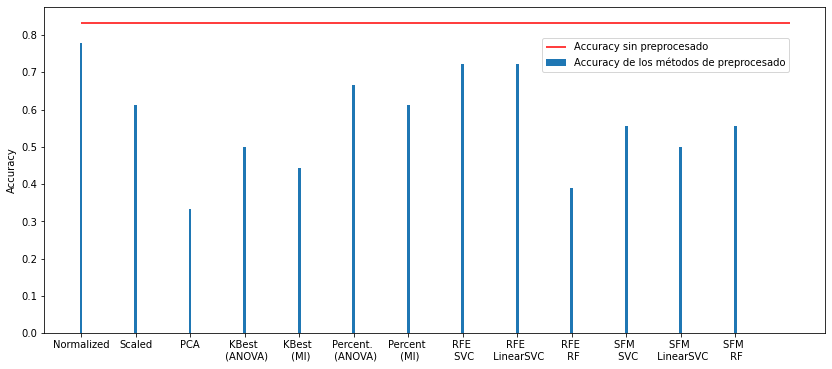

In [36]:
import matplotlib.pyplot as plt

results = [acc_normalized, acc_scaled, acc_pca, acc_select_k, acc_select_k2, acc_select_percent, acc_select_percent2,
          acc_rfe_svc, acc_rfe_linearsvc, acc_rfe_rf, acc_sfm_svc, acc_sfm_linearsvc, acc_sfm_rf]

plt.figure(figsize=(14, 6))
xaxis = ["Normalized", "Scaled", "PCA", "KBest \n (ANOVA)", "KBest \n (MI)", "Percent. \n (ANOVA)", "Percent \n (MI)",
         "RFE \n SVC", "RFE \n LinearSVC", "RFE \n RF", "SFM \n SVC", "SFM \n LinearSVC", "SFM \n RF"]
plt.bar(xaxis, results, width=0.05, label="Accuracy de los métodos de preprocesado")
plt.hlines(xmin=0, xmax=13, y=accuracy_no_preprocessing, color="red", label="Accuracy sin preprocesado")
plt.legend(bbox_to_anchor=(0.96, 0.92))
plt.ylabel("Accuracy")
plt.show()